In [385]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [386]:
data = pd.read_csv("match_data_v5.csv")
# drops missing values
data.dropna()


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,EUW1_6882489515',2,23,4,2,0,0,0,7,0,...,2,0,1,400,94,29637,32613,27239,1,0
1,EUW1_6882416210',2,46,12,1,0,1,0,10,0,...,1,0,4,373,76,28970,30320,36585,0,0
2,EUW1_6881092720',2,19,13,0,0,0,0,11,0,...,2,0,3,340,84,30510,29464,42984,0,0
3,EUW1_6879405717',3,28,8,0,1,1,0,9,1,...,0,0,5,378,87,25157,31069,28229,0,0
4,EUW1_6879389461',3,30,11,1,1,1,0,7,0,...,1,0,5,382,96,26052,29475,19245,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24220,EUW1_6879062849',0,27,1,1,0,0,0,5,0,...,0,0,0,370,102,26134,30760,22845,0,0
24221,EUW1_6878994449',4,29,5,0,0,0,0,4,0,...,1,0,2,365,80,25169,30857,29694,0,0
24222,EUW1_6878933095',1,25,16,1,1,1,0,11,0,...,1,0,4,342,81,30528,29566,36545,0,0
24223,EUW1_6883217488',4,27,15,0,0,1,0,9,0,...,2,0,2,341,74,31761,30573,42858,0,0


## Data Pre-Processing

In [387]:
# remove instances where plates destroyed and towers destroyed don't line up
data = data[data.iloc[:, 20] > (data.iloc[:, 8] - 12)]
data = data[data.iloc[:, 22] > (data.iloc[:, 6] - 12)]

# there are only 15 plates in a match, remove instances where more than 15 plates are destroyed
data = data[data.iloc[:, 8] <= 15]
data = data[data.iloc[:, 22] <= 15]

# remove instances with more than 70 wards placed, greater than 70 are outliers
data = data[data.iloc[:, 2] <= 70]

In [388]:
data.columns = [
    "matchID", "blue_control_wards", "blue_wards", "blue_kills", "blue_dragons", "blue_heralds",
    "blue_towers", "blue_inhibs", "red_plates", "blue_first_blood", "blue_minions",
    "blue_jungle", "blue_gold", "blue_xp", "blue_dmg", "red_control_wards",
    "red_wards", "red_kills", "red_dragons", "red_heralds", "red_towers",
    "red_inhibs", "blue_plates", "red_minions", "red_jungle", "red_gold",
    "red_xp", "red_dmg", "blue_win", "null"
]

# drop unnecessary id and empty column
data = data.drop(columns=["matchID"])
data = data.drop(columns=["null"])

data.head()

,blue_control_wards,blue_wards,blue_kills,blue_dragons,blue_heralds,blue_towers,blue_inhibs,red_plates,blue_first_blood,blue_minions,...,red_heralds,red_towers,red_inhibs,blue_plates,red_minions,red_jungle,red_gold,red_xp,red_dmg,blue_win
0,2,23,4,2,0,0,0,7,0,388,...,0,2,0,1,400,94,29637,32613,27239,1
1,2,46,12,1,0,1,0,10,0,348,...,0,1,0,4,373,76,28970,30320,36585,0
2,2,19,13,0,0,0,0,11,0,331,...,0,2,0,3,340,84,30510,29464,42984,0
3,3,28,8,0,1,1,0,9,1,355,...,0,0,0,5,378,87,25157,31069,28229,0
4,3,30,11,1,1,1,0,7,0,370,...,0,1,0,5,382,96,26052,29475,19245,1


In [389]:
corr = data.corr()
corr["blue_win"].sort_values(ascending=False)

blue_win              1.000000
blue_gold             0.451825
blue_xp               0.434904
blue_kills            0.389112
blue_plates           0.321951
blue_dragons          0.315154
blue_towers           0.312680
blue_dmg              0.286868
blue_minions          0.239813
blue_jungle           0.203369
blue_first_blood      0.167305
blue_heralds          0.104679
blue_control_wards    0.054371
blue_inhibs           0.037322
blue_wards            0.022424
red_wards            -0.000073
red_inhibs           -0.009278
red_control_wards    -0.054340
red_heralds          -0.107104
red_jungle           -0.200527
red_towers           -0.241999
red_plates           -0.242901
red_minions          -0.259386
red_dmg              -0.276295
red_dragons          -0.308564
red_kills            -0.371216
red_xp               -0.431990
red_gold             -0.437823
Name: blue_win, dtype: float64

In [390]:
# drop those with abs(corr) less than 0.1
data = data.drop(columns=["blue_control_wards"])
data = data.drop(columns=["blue_inhibs"])
data = data.drop(columns=["blue_wards"])
data = data.drop(columns=["red_control_wards"])
data = data.drop(columns=["red_inhibs"])
data = data.drop(columns=["red_wards"])

data.describe()

,blue_kills,blue_dragons,blue_heralds,blue_towers,red_plates,blue_first_blood,blue_minions,blue_jungle,blue_gold,blue_xp,...,red_dragons,red_heralds,red_towers,blue_plates,red_minions,red_jungle,red_gold,red_xp,red_dmg,blue_win
count,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,...,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000
mean,12.834926,0.744873,0.126294,0.662236,8.364994,0.513590,351.145958,88.425478,27885.272252,29654.898945,...,0.894663,0.096326,0.876593,3.969883,349.559040,88.245022,27557.553365,29535.489148,31847.767523,0.512296
std,4.919872,0.723530,0.332339,0.894696,2.599595,0.499828,30.955731,14.040551,2744.487275,1858.174411,...,0.746879,0.295045,0.917763,2.612727,31.666999,13.993267,2574.101185,1873.576445,5921.364220,0.499861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,17719.000000,19061.000000,...,0.000000,0.000000,0.000000,0.000000,188.000000,0.000000,18247.000000,17602.000000,10383.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,7.000000,0.000000,331.000000,79.000000,25960.000000,28421.000000,...,0.000000,0.000000,0.000000,2.000000,329.000000,79.000000,25787.750000,28326.000000,27788.000000,0.000000
50%,12.000000,1.000000,0.000000,0.000000,8.000000,1.000000,352.000000,88.000000,27718.000000,29659.000000,...,1.000000,0.000000,1.000000,4.000000,351.000000,88.000000,27426.500000,29558.000000,31641.000000,1.000000
75%,16.000000,1.000000,0.000000,1.000000,10.000000,1.000000,373.000000,98.000000,29630.000000,30907.250000,...,1.000000,0.000000,1.000000,6.000000,371.000000,97.000000,29198.000000,30763.000000,35695.000000,1.000000
max,38.000000,2.000000,2.000000,10.000000,15.000000,1.000000,465.000000,156.000000,40968.000000,36801.000000,...,2.000000,1.000000,8.000000,15.000000,464.000000,156.000000,40168.000000,36431.000000,62452.000000,1.000000


In [391]:
X = data.drop(["blue_win"], axis=1)
y = data["blue_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

column = X_train.columns

scaler = StandardScaler().fit(X_train)
X_train_scale = pd.DataFrame(scaler.transform(X_train), columns = column)
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns = column)

y_2d_train = np.reshape(y_train, (y_train.shape[0], 1))
y_2d_test = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_scale)
# print(y_2d_train)

       blue_kills  blue_dragons  blue_heralds  blue_towers  red_plates  \
0        1.849184      0.349457     -0.383535     1.489819   -0.908428   
1       -0.174056      0.349457     -0.383535    -0.741245    0.246736   
2        1.242212      0.349457     -0.383535     0.374287   -0.908428   
3       -0.781028      0.349457     -0.383535    -0.741245   -0.138319   
4       -0.983352      0.349457     -0.383535    -0.741245   -0.138319   
...           ...           ...           ...          ...         ...   
15061    0.028268      1.732049     -0.383535    -0.741245   -1.293483   
15062    0.432916      0.349457     -0.383535    -0.741245   -0.523374   
15063   -0.174056      1.732049     -0.383535    -0.741245   -1.678538   
15064   -1.590324      1.732049     -0.383535    -0.741245   -0.523374   
15065   -0.578704     -1.033136     -0.383535     0.374287    1.401900   

       blue_first_blood  blue_minions  blue_jungle  blue_gold   blue_xp  ...  \
0              0.969662      0.

## PCA

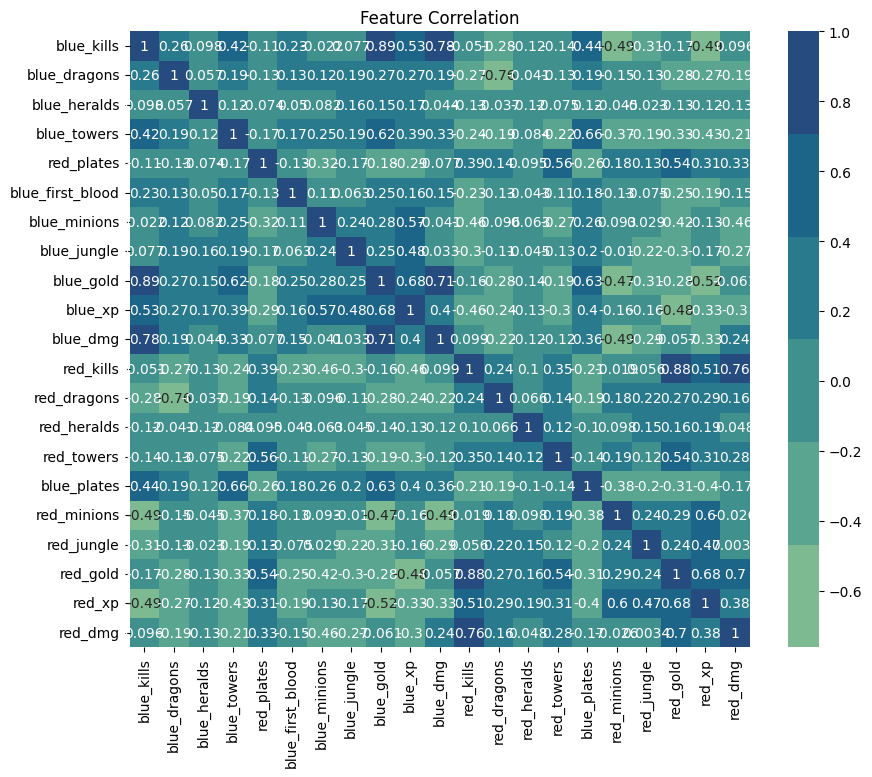

In [392]:
corr = X_train_scale.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True, cmap=sns.color_palette("crest"),edgecolor="k")
plt.title("Feature Correlation")
plt.show()

In [393]:
pca = PCA(n_components=1)

features = X_train_scale[['blue_kills', 'blue_gold', "blue_dmg"]]
principal_component = pca.fit_transform(features)
X_train_scale["blue_kills_gold_dmg"] = principal_component

features = X_train_scale[['red_kills', 'red_gold', "red_dmg"]]
principal_component = pca.fit_transform(features)
X_train_scale["red_kills_gold_dmg"] = principal_component

features = X_train_scale[['blue_xp', 'blue_minions', "blue_jungle", "blue_gold"]]
principal_component = pca.fit_transform(features)
X_train_scale["blue_xp_minions_jungle_gold"] = principal_component

features = X_train_scale[['red_xp', 'red_minions', "red_jungle", "red_gold"]]
principal_component = pca.fit_transform(features)
X_train_scale["red_xp_minions_jungle_gold"] = principal_component

features = X_train_scale[['red_plates', 'red_gold', 'red_towers']]
principal_component = pca.fit_transform(features)
X_train_scale["red_plates_gold_towers"] = principal_component

features = X_train_scale[['blue_plates', 'blue_gold', 'blue_towers']]
principal_component = pca.fit_transform(features)
X_train_scale["blue_plates_gold_towers"] = principal_component

X_train_scale = X_train_scale.drop(columns = ["blue_kills"])
X_train_scale = X_train_scale.drop(columns = ["blue_gold"])
X_train_scale = X_train_scale.drop(columns = ["blue_dmg"])
X_train_scale = X_train_scale.drop(columns = ["blue_xp"])
X_train_scale = X_train_scale.drop(columns = ["blue_minions"])
X_train_scale = X_train_scale.drop(columns = ["blue_jungle"])
X_train_scale = X_train_scale.drop(columns = ["blue_plates"])
X_train_scale = X_train_scale.drop(columns = ["blue_towers"])
X_train_scale = X_train_scale.drop(columns = ["red_kills"])
X_train_scale = X_train_scale.drop(columns = ["red_gold"])
X_train_scale = X_train_scale.drop(columns = ["red_dmg"])
X_train_scale = X_train_scale.drop(columns = ["red_xp"])
X_train_scale = X_train_scale.drop(columns = ["red_minions"])
X_train_scale = X_train_scale.drop(columns = ["red_jungle"])
X_train_scale = X_train_scale.drop(columns = ["red_plates"])
X_train_scale = X_train_scale.drop(columns = ["red_towers"])

print(X_train_scale)

       blue_dragons  blue_heralds  blue_first_blood  red_dragons  red_heralds  \
0          0.349457     -0.383535          0.969662     0.142975    -0.323460   
1          0.349457     -0.383535          0.969662    -1.198281     3.091571   
2          0.349457     -0.383535         -1.031287    -1.198281    -0.323460   
3          0.349457     -0.383535          0.969662    -1.198281    -0.323460   
4          0.349457     -0.383535          0.969662     0.142975     3.091571   
...             ...           ...               ...          ...          ...   
15061      1.732049     -0.383535         -1.031287    -1.198281    -0.323460   
15062      0.349457     -0.383535          0.969662     0.142975    -0.323460   
15063      1.732049     -0.383535         -1.031287    -1.198281    -0.323460   
15064      1.732049     -0.383535         -1.031287    -1.198281    -0.323460   
15065     -1.033136     -0.383535          0.969662     1.484231    -0.323460   

       blue_kills_gold_dmg 

In [394]:
pca = PCA(n_components=1)

features = X_test_scale[['blue_kills', 'blue_gold', "blue_dmg"]]
principal_component = pca.fit_transform(features)
X_test_scale["blue_kills_gold_dmg"] = principal_component

features = X_test_scale[['red_kills', 'red_gold', "red_dmg"]]
principal_component = pca.fit_transform(features)
X_test_scale["red_kills_gold_dmg"] = principal_component

features = X_test_scale[['blue_xp', 'blue_minions', "blue_jungle", "blue_gold"]]
principal_component = pca.fit_transform(features)
X_test_scale["blue_xp_minions_jungle_gold"] = principal_component

features = X_test_scale[['red_xp', 'red_minions', "red_jungle", "red_gold"]]
principal_component = pca.fit_transform(features)
X_test_scale["red_xp_minions_jungle_gold"] = principal_component

features = X_test_scale[['red_plates', 'red_gold', 'red_towers']]
principal_component = pca.fit_transform(features)
X_test_scale["red_plates_gold_towers"] = principal_component

features = X_test_scale[['blue_plates', 'blue_gold', 'blue_towers']]
principal_component = pca.fit_transform(features)
X_test_scale["blue_plates_gold_towers"] = principal_component

X_test_scale = X_test_scale.drop(columns = ["blue_kills"])
X_test_scale = X_test_scale.drop(columns = ["blue_gold"])
X_test_scale = X_test_scale.drop(columns = ["blue_dmg"])
X_test_scale = X_test_scale.drop(columns = ["blue_xp"])
X_test_scale = X_test_scale.drop(columns = ["blue_minions"])
X_test_scale = X_test_scale.drop(columns = ["blue_jungle"])
X_test_scale = X_test_scale.drop(columns = ["blue_plates"])
X_test_scale = X_test_scale.drop(columns = ["blue_towers"])
X_test_scale = X_test_scale.drop(columns = ["red_kills"])
X_test_scale = X_test_scale.drop(columns = ["red_gold"])
X_test_scale = X_test_scale.drop(columns = ["red_dmg"])
X_test_scale = X_test_scale.drop(columns = ["red_xp"])
X_test_scale = X_test_scale.drop(columns = ["red_minions"])
X_test_scale = X_test_scale.drop(columns = ["red_jungle"])
X_test_scale = X_test_scale.drop(columns = ["red_plates"])
X_test_scale = X_test_scale.drop(columns = ["red_towers"])

print(X_test_scale)

      blue_dragons  blue_heralds  blue_first_blood  red_dragons  red_heralds  \
0        -1.033136     -0.383535         -1.031287     0.142975    -0.323460   
1         1.732049     -0.383535          0.969662    -1.198281    -0.323460   
2         0.349457     -0.383535          0.969662     0.142975     3.091571   
3         0.349457     -0.383535         -1.031287     0.142975    -0.323460   
4        -1.033136     -0.383535          0.969662     1.484231     3.091571   
...            ...           ...               ...          ...          ...   
5017      0.349457     -0.383535         -1.031287    -1.198281    -0.323460   
5018      1.732049     -0.383535          0.969662    -1.198281    -0.323460   
5019     -1.033136     -0.383535         -1.031287     1.484231     3.091571   
5020     -1.033136     -0.383535         -1.031287    -1.198281    -0.323460   
5021      0.349457     -0.383535          0.969662     0.142975    -0.323460   

      blue_kills_gold_dmg  red_kills_go

In [395]:
X_train_scale['kills_gold_dmg_difference'] = X_train_scale["blue_kills_gold_dmg"] - X_train_scale["red_kills_gold_dmg"]
X_train_scale['xp_minions_jungle_gold_difference'] = X_train_scale['blue_xp_minions_jungle_gold'] - X_train_scale['red_xp_minions_jungle_gold']
X_train_scale['plates_gold_towers_difference'] = X_train_scale["blue_plates_gold_towers"] - X_train_scale["red_plates_gold_towers"]
X_train_scale['dragons_difference'] = X_train_scale['blue_dragons'] - X_train_scale['red_dragons']
X_train_scale['heralds_difference'] = X_train_scale["blue_heralds"] - X_train_scale["red_heralds"]
X_train_scale['first_blood_difference'] = X_train_scale['blue_first_blood'] * 2 - 1

X_train_scale = X_train_scale.drop(columns = ["blue_kills_gold_dmg"])
X_train_scale = X_train_scale.drop(columns = ["red_kills_gold_dmg"])
X_train_scale = X_train_scale.drop(columns = ['blue_xp_minions_jungle_gold'])
X_train_scale = X_train_scale.drop(columns = ["red_xp_minions_jungle_gold"])
X_train_scale = X_train_scale.drop(columns = ["blue_plates_gold_towers"])
X_train_scale = X_train_scale.drop(columns = ["red_plates_gold_towers"])
X_train_scale = X_train_scale.drop(columns = ['blue_dragons'])
X_train_scale = X_train_scale.drop(columns = ['red_dragons'])
X_train_scale = X_train_scale.drop(columns = ["blue_heralds"])
X_train_scale = X_train_scale.drop(columns = ["red_heralds"])
X_train_scale = X_train_scale.drop(columns = ['blue_first_blood'])

print(X_train_scale)


       kills_gold_dmg_difference  xp_minions_jungle_gold_difference  \
0                       4.942162                          -4.710615   
1                      -1.448487                           3.191232   
2                       2.612787                          -1.380285   
3                      -1.468442                           1.692398   
4                      -3.016998                           3.295161   
...                          ...                                ...   
15061                  -0.346421                           1.010103   
15062                  -0.802386                          -0.382803   
15063                  -1.109315                          -0.308597   
15064                  -2.273743                           0.391622   
15065                   2.232239                          -1.715903   

       plates_gold_towers_difference  dragons_difference  heralds_difference  \
0                           4.415918            0.206482           

In [396]:
X_test_scale['kills_gold_dmg_difference'] = X_test_scale["blue_kills_gold_dmg"] - X_test_scale["red_kills_gold_dmg"]
X_test_scale['xp_minions_jungle_gold_difference'] = X_test_scale['blue_xp_minions_jungle_gold'] - X_test_scale['red_xp_minions_jungle_gold']
X_test_scale['plates_gold_towers_difference'] = X_test_scale["blue_plates_gold_towers"] - X_test_scale["red_plates_gold_towers"]
X_test_scale['dragons_difference'] = X_test_scale['blue_dragons'] - X_test_scale['red_dragons']
X_test_scale['heralds_difference'] = X_test_scale["blue_heralds"] - X_test_scale["red_heralds"]
X_test_scale['first_blood_difference'] = X_test_scale['blue_first_blood'] * 2 - 1

X_test_scale = X_test_scale.drop(columns = ["blue_kills_gold_dmg"])
X_test_scale = X_test_scale.drop(columns = ["red_kills_gold_dmg"])
X_test_scale = X_test_scale.drop(columns = ['blue_xp_minions_jungle_gold'])
X_test_scale = X_test_scale.drop(columns = ["red_xp_minions_jungle_gold"])
X_test_scale = X_test_scale.drop(columns = ["blue_plates_gold_towers"])
X_test_scale = X_test_scale.drop(columns = ["red_plates_gold_towers"])
X_test_scale = X_test_scale.drop(columns = ['blue_dragons'])
X_test_scale = X_test_scale.drop(columns = ['red_dragons'])
X_test_scale = X_test_scale.drop(columns = ["blue_heralds"])
X_test_scale = X_test_scale.drop(columns = ["red_heralds"])
X_test_scale = X_test_scale.drop(columns = ['blue_first_blood'])

print(X_test_scale)


      kills_gold_dmg_difference  xp_minions_jungle_gold_difference  \
0                     -4.305841                           4.944571   
1                      1.690168                           0.378126   
2                     -0.090613                           0.621219   
3                      0.995500                          -2.826449   
4                     -1.321695                           4.300171   
...                         ...                                ...   
5017                   0.786184                          -0.873256   
5018                   1.675848                          -0.875021   
5019                  -1.531113                           2.080014   
5020                  -0.004732                           0.131941   
5021                  -1.570598                           1.593588   

      plates_gold_towers_difference  dragons_difference  heralds_difference  \
0                         -5.536619           -1.176111           -0.060075   
1

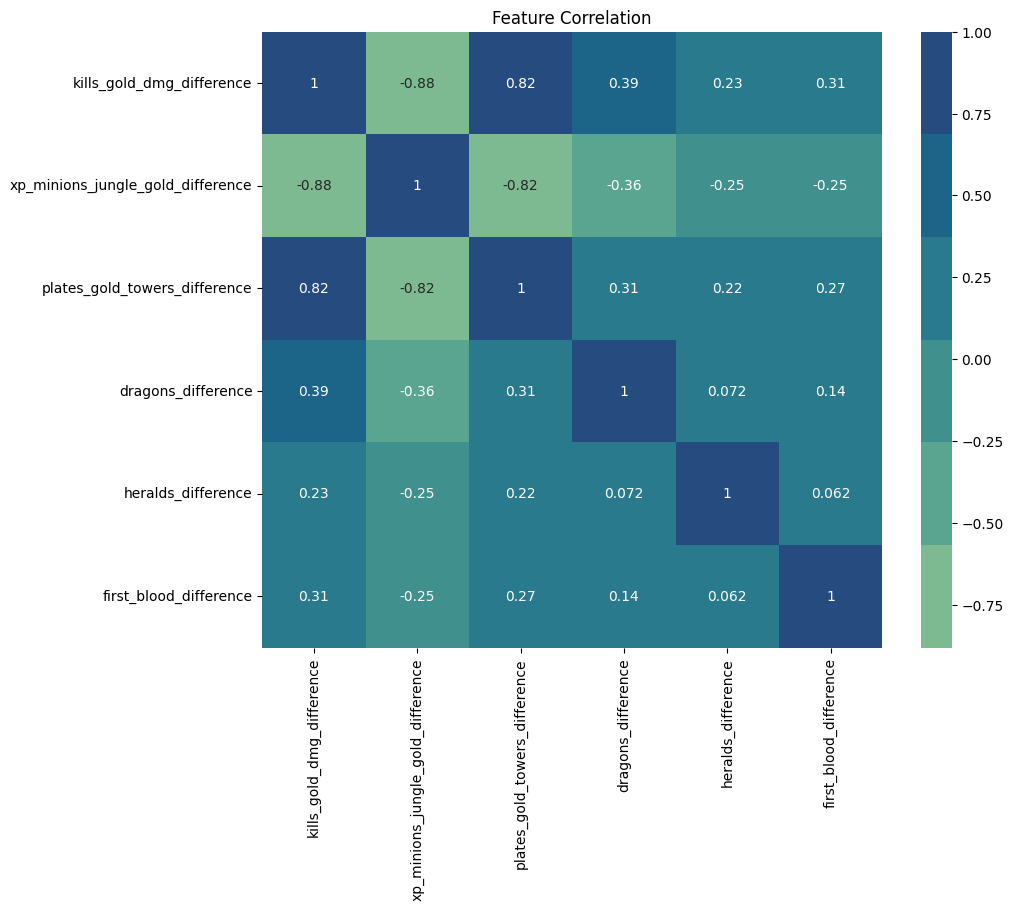

In [397]:
corr = X_train_scale.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True, cmap=sns.color_palette("crest"),edgecolor="k")
plt.title("Feature Correlation")
plt.show()

In [398]:
X_train_scale = X_train_scale.to_numpy()
X_test_scale = X_test_scale.to_numpy()

print(X_train_scale)
print(X_test_scale)

[[ 4.94216191 -4.71061536  4.41591835  0.20648187 -0.06007518  0.9393243 ]
 [-1.44848748  3.1912323  -2.82525059  1.54773779 -3.47510666  0.9393243 ]
 [ 2.61278667 -1.38028544  2.06014091  1.54773779 -0.06007518 -3.06257406]
 ...
 [-1.10931466 -0.30859732 -0.24540391  2.93033045 -0.06007518 -3.06257406]
 [-2.27374321  0.39162207 -1.32687087  2.93033045 -0.06007518 -3.06257406]
 [ 2.23223948 -1.71590319  0.311516   -2.51736671 -0.06007518  0.9393243 ]]
[[-4.30584084e+00  4.94457085e+00 -5.53661926e+00 -1.17611079e+00
  -6.00751779e-02 -3.06257406e+00]
 [ 1.69016757e+00  3.78125924e-01  2.38510290e+00  2.93033045e+00
  -6.00751779e-02  9.39324303e-01]
 [-9.06133987e-02  6.21218825e-01  1.21509925e+00  2.06481870e-01
  -3.47510666e+00  9.39324303e-01]
 ...
 [-1.53111284e+00  2.08001371e+00 -1.72702499e+00 -2.51736671e+00
  -3.47510666e+00 -3.06257406e+00]
 [-4.73205839e-03  1.31941084e-01 -1.82452423e-01  1.65145125e-01
  -6.00751779e-02 -3.06257406e+00]
 [-1.57059793e+00  1.59358846e+00 

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_prec = precision_score(y_train, y_train_pred)
    test_prec = precision_score(y_test, y_test_pred)
    train_rec = recall_score(y_train, y_train_pred)
    test_rec = recall_score(y_test, y_test_pred)
    
    return train_acc, test_acc, train_prec, test_prec, train_rec, test_rec

## Logistic Regression with L1 Regularizaton

In [ ]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear')
model_l1.fit(X_train_scale, y_train)
results_l1 = evaluate_model(model_l1, X_train_scale, X_test_scale, y_train, y_test)

## Logistic Regression with L2 Regularizaton

## SVM

## Neural Network